# Info

- building a baseline model using the cats vs. dogs architecture.
- this baseline model includes a preprocessing steps of rescaling of all images to 80x80 size with a single channel (gray scale)
- this baseline model is built for binary classification:
    - output layer has a Sigmoid activation function 
    - loss function is binary_crossentropy
    - chosen metrics is AUC with and accuracy

# Setup

## import libraries and modules

In [48]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import os
import cv2
import numpy as np
from pathlib import Path
from multiprocessing import Pool
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

## set constants

In [15]:
TRAIN_META = 'train.csv'

TRAIN_IMG_DIR = Path('train') 
TRAIN_RESIZE_DIR = Path('BaselineSingleLabel/train_resize') 

TEST_IMG_DIR = Path('test') 
TEST_RESIZE_DIR = Path('BaselineSingleLabel/test_resize') 

CASE = 'StudyInstanceUID'
NEW_SIZE = (80,80)
IMG_SIZE = (80, 80, 1)

VALIDATION_SIZE = 0.2
RANDOM_STATE = 42

RSCL = 1/255
ACTIVATION = 'relu'
N_FILTERS = 64
FILTER2D_size = 1
METRICS = [AUC(), 'accuracy']
DENSE_DIM = 64
OUT_DIM = 1
OUT_ACTIVATION = 'sigmoid'
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
EPOCHS = 100
BATCH_SIZE = 32
AVAIL_CPU = None

os.makedirs(TRAIN_RESIZE_DIR, exist_ok=True)
os.makedirs(TEST_RESIZE_DIR, exist_ok=True)
np.random.seed(RANDOM_STATE)

## load meta file

In [3]:
df = pd.read_csv(TRAIN_META)

## get labels

In [4]:
labels = df.select_dtypes(int).columns

## functions

In [5]:
def show_img(img: np.array, ax=None, title: str='', cmap: str = 'gray'):
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(img, cmap=cmap, ax=ax)
    ax.set_title(title)
    
def preprocess(img_path: Path, processed_path: Path):
    new_img = cv2.resize(cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE), NEW_SIZE)
    cv2.imwrite(str(processed_path), new_img)
    

def validate_file(record: Path):
    if record.is_file() & record.exists():
        return True
    return False


def numipy_train(meta: pd.DataFrame, img_dir: Path, suffix: str = '.jpg', 
                 case_col: str = CASE, labels_col = labels, 
                 scale=cv2.IMREAD_GRAYSCALE, image_dir_temp_col = 'images', 
                 cpu: int=None, binary_label: str = None):
    
    meta[image_dir_temp_col] = img_dir / (meta[case_col] + suffix)
    msk = meta[image_dir_temp_col].apply(validate_file)
    meta = meta[msk]
    if binary_label:
        binary_label = [label for label in labels_col if binary_label in label]
        label_values = np.any(meta[binary_label], axis=1).values
    else:
        label_values = meta[labels_col].values
    images = meta[image_dir_temp_col].to_list() 
    images = [(str(image), scale) for image in images]
    with Pool(cpu) as p: images = p.starmap(cv2.imread, images)
    return np.array(images), label_values


def multi_preprocess(input_dir: Path, output_dir: Path, glob: str='*.jpg',
                      size: tuple=NEW_SIZE, scale=cv2.IMREAD_GRAYSCALE, 
                      clip_limit=None, title_grid_size=None, 
                      cpu: int=None):
    pool_lst = []
    os.makedirs(output_dir, exist_ok=True)
    for input_img in input_dir.glob(glob):
        pool_lst.append((input_img, output_dir/input_img.name, size, scale, clip_limit, title_grid_size))
    with Pool(cpu) as p: p.starmap(preprocess, pool_lst)


# Preprocess

## preprocess train

In [6]:
multi_preprocess(TRAIN_IMG_DIR, TRAIN_RESIZE_DIR)

## preprocess test

In [7]:
multi_preprocess(TEST_IMG_DIR, TEST_RESIZE_DIR)

## convert train into numpy array

In [8]:
X_train, y_train = numipy_train(df, TRAIN_RESIZE_DIR, binary_label='CVC')

# basic CNN

## make sequential model architecture

In [9]:
model = Sequential([Rescaling(RSCL, input_shape=IMG_SIZE, name='rescaling'),
                    Conv2D(N_FILTERS, FILTER2D_size, activation=ACTIVATION, name='conv_1'), 
                    MaxPooling2D(name='max_pool1'),  
                    Conv2D(N_FILTERS, FILTER2D_size, activation=ACTIVATION, name='conv_2'), 
                    MaxPooling2D(name='max_pool2'), 
                    Conv2D(N_FILTERS, FILTER2D_size, activation=ACTIVATION, name='conv_3'),
                    MaxPooling2D(name='max_pool3'), 
                    Flatten(name='flat'), 
                    Dense(DENSE_DIM, activation=ACTIVATION, name='dense_1'), 
                    Dense(1, activation=OUT_ACTIVATION, name='out')])

## model summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 80, 80, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 80, 80, 64)        128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 40, 40, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 40, 40, 64)        4160      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 20, 20, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 20, 20, 64)        4160      
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 10, 10, 64)        0

## Callbacks

In [11]:
checkpoint = ModelCheckpoint("Checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=1, 
save_best_only=False, save_weights_only=False, mode='auto')
callback = EarlyStopping(monitor='val_loss', patience=5)

## compile model

In [16]:
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

# train

In [17]:
model.fit(X_train, y_train, validation_split=VALIDATION_SIZE, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpoint, callback])

Epoch 1/100
753/753 [==============================] - 50s 66ms/step - loss: 0.1311 - auc: 0.6050 - accuracy: 0.9643 - val_loss: 0.1005 - val_auc: 0.7431 - val_accuracy: 0.9776

Epoch 00001: saving model to Checkpoint/weights.01-0.10.hdf5
Epoch 2/100
753/753 [==============================] - 47s 63ms/step - loss: 0.1152 - auc: 0.6653 - accuracy: 0.9743 - val_loss: 0.0982 - val_auc: 0.7587 - val_accuracy: 0.9776

Epoch 00002: saving model to Checkpoint/weights.02-0.10.hdf5
Epoch 3/100
753/753 [==============================] - 47s 63ms/step - loss: 0.1155 - auc: 0.7041 - accuracy: 0.9734 - val_loss: 0.1024 - val_auc: 0.7657 - val_accuracy: 0.9776

Epoch 00003: saving model to Checkpoint/weights.03-0.10.hdf5
Epoch 4/100
753/753 [==============================] - 47s 62ms/step - loss: 0.1107 - auc: 0.7059 - accuracy: 0.9748 - val_loss: 0.0983 - val_auc: 0.7574 - val_accuracy: 0.9776

Epoch 00004: saving model to Checkpoint/weights.04-0.10.hdf5
Epoch 5/100
753/753 [=======================

# evaluation

In [49]:
pred = np.where(model.predict(X_train)<0.5, 0, 1) 

In [45]:
cm = confusion_matrix(y_train, np.where(model.predict(X_train)<0.5, 0, 1))

In [52]:
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

       False       1.00      0.01      0.02       750
        True       0.98      1.00      0.99     29333

    accuracy                           0.98     30083
   macro avg       0.99      0.50      0.50     30083
weighted avg       0.98      0.98      0.96     30083



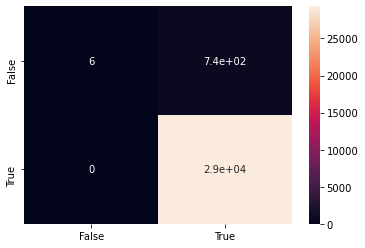

In [55]:
sns.heatmap(pd.DataFrame(cm, index = ['False', 'True'], columns = ['False', 'True']), annot=True)
plt.show()